In [27]:
import sympy as sp

x, y = sp.var("x,y", real=True)
X = x + sp.I * y
x0, y0 = sp.var("x0,y0", real=True)
X0 = x0 + sp.I * y0
xc, yc = sp.var("xc,yx", real=True)
XC = xc + sp.I * yc
dx = x - x0
dy = y - y0
r2 = dx * dx + dy * dy


In [28]:
sp.re((X - X0) / sp.conjugate(X - X0))


(x - x0)**2/((x - x0)**2 + (-y + y0)**2) - (y - y0)**2/((x - x0)**2 + (-y + y0)**2)

In [29]:
f = (1 / (X - X0))
f = sp.re(X - X0) / (X - X0)
sp.re(f)

(x - x0)**2/((x - x0)**2 + (y - y0)**2)

In [30]:
sp.im(f)

(x - x0)*(-y + y0)/((x - x0)**2 + (y - y0)**2)

In [35]:
sp.re(sp.log(X - X0) + sp.conjugate(sp.log(X - X0)))


2*log(sqrt(x**2 - 2*x*x0 + x0**2 + y**2 - 2*y*y0 + y0**2))

In [83]:
sp.re((X - X0) / np.conjugate(X - X0) - sp.im(sp.im(X - X0) / (X - X0))).simplify()

(x - x0)**2/((x - x0)**2 + (y - y0)**2)

In [109]:
sp.im((X - X0) / np.conjugate(X - X0) - sp.im(sp.im(X - X0) / (X - X0))).simplify()

2*(x - x0)*(y - y0)/((x - x0)**2 + (y - y0)**2)

In [8]:
(sp.re(sp.log(X - X0) + sp.conjugate(sp.log(X - X0)))).simplify()


log(x**2 - 2*x*x0 + x0**2 + y**2 - 2*y*y0 + y0**2)

In [9]:
sp.log(r2)


log((x - x0)**2 + (y - y0)**2)

In [10]:
dx * dy / r2


(x - x0)*(y - y0)/((x - x0)**2 + (y - y0)**2)

In [87]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import refine_surfaces, gauss_rule
from tectosaur2.mesh import pts_grid

nobs = 100
V = 2
zoomx = [-V, V]
zoomy = [-V, V]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

t = sp.var("t")
(fault,) = refine_surfaces([(t, t, t)], gauss_rule(12))


In [88]:
shear_modulus = 1.0  # 3e10
poisson_ratio = 0.25


In [89]:
src = fault
d = [
    obs_pts[:, 0, None] - src.pts[None, :, 0],
    obs_pts[:, 1, None] - src.pts[None, :, 1],
]
r2 = d[0] * d[0] + d[1] * d[1]
too_close = r2 <= 1e-16
r2[too_close] = 1

r = np.sqrt(r2)
trac_C1 = 1.0 / (4 * np.pi * (1 - poisson_ratio))
trac_C2 = 1 - 2.0 * poisson_ratio

drdn = (d[0] * src.normals[None, :, 0] + d[1] * src.normals[None, :, 1]) / r
T = np.empty((obs_pts.shape[0], 2, src.n_pts, 2))
for d_obs in range(2):
    for d_src in range(2):
        t1 = trac_C2 * (d_obs == d_src) + 2 * d[d_obs] * d[d_src] / r2
        t2 = (
            trac_C2
            * (
                src.normals[None, :, d_src] * d[d_obs]
                - src.normals[None, :, d_obs] * d[d_src]
            )
            / r
        )
        T[:, d_obs, :, d_src] = -(trac_C1 / r) * (t1 * drdn - t2)


In [90]:
slip = np.full((fault.n_pts, 2), 1.0 / np.sqrt(2))


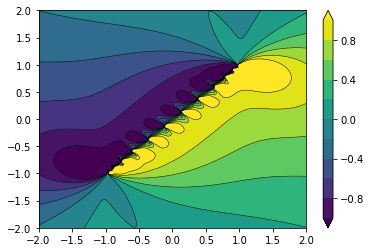

In [91]:
disp = np.sum(T * slip[None, None, :, :], axis=(2, 3))
v2d = disp.reshape((nobs, nobs, 2))[:, :, 0]
levels = np.linspace(-1, 1, 11)
cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
plt.contour(
    xs,
    ys,
    v2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()


In [92]:
disp_C1 = 1.0 / (8 * np.pi * shear_modulus * (1 - poisson_ratio))
disp_C2 = 3 - 4 * poisson_ratio
S = np.empty((obs_pts.shape[0], 2, src.n_pts, 2))
for d_obs in range(2):
    for d_src in range(2):
        S[:, d_obs, :, d_src] = disp_C1 * (
            -0.5 * (3 - 4 * poisson_ratio) * (d_obs == d_src) * np.log(r2)
            + d[d_obs] * d[d_src] / r2
        )


In [114]:
[disp_C1 * d[d_obs][10, 0] * d[0][10, 0] / r2[10, 0] for d_obs in range(2)]
S[10, :, 0, 0]


array([-0.00424894,  0.0234649 ])

In [118]:
kappa = 3 - 4 * poisson_ratio
z = obs_pts[10, 0] + obs_pts[10, 1] * 1j
w = src.pts[0, 0] + src.pts[0, 1] * 1j
disp_C1 * (
    -0.5 * kappa * (np.log(z - w) + np.conjugate(np.log(z - w)))
    - 1.0 * np.real(
        (z - w) / np.conjugate(z - w)
        + np.imag(np.imag(z - w) / (z - w))
    )
    - 0.5 * (z - w) / np.conjugate(z - w)
)


(0.057601249634176004-0.02346489919230456j)

In [119]:
(d[0] * d[0] / r2)[10,0]

0.2668302795403065

In [112]:
0.5 * (
    (z - w) / np.conjugate(z - w)
    + np.imag(np.imag(z - w) / (z - w))
)

(-0.5997545806895401+0.44230292951861444j)

In [120]:
S2 = np.empty((obs_pts.shape[0], src.n_pts, 2), dtype=np.complex128)
kappa = 3 - 4 * poisson_ratio
z = obs_pts[:, None, 0] + obs_pts[:, None, 1] * 1j
z0 = src.pts[None, :, 0] + src.pts[None, :, 1] * 1j
for d_src in range(2):
    P = (d_src == 0) + (d_src == 1) * 1j
    print(P, np.conjugate(P))
    t1 = -kappa * P * (np.log(z0 - z) + np.conjugate(np.log(z0 - z)))
    t2 = np.conjugate(P) * ((z0 - z) / (np.conjugate(z0 - z)))
    S2[:, :, d_src] = 1.0 / (4 * np.pi * shear_modulus * (1 + kappa)) * (t1 + t2)


(1+0j) (1-0j)
1j -1j


In [121]:
S2[0, 0, 0], S[0, :, 0, 0]


((-0.038711258113763955+0.026525823848649224j),
 array([-0.01218543,  0.02652582]))

In [122]:
S2[0, 0, 1], S[0, :, 0, 1]


((0.026525823848649224-0.038711258113763955j),
 array([ 0.02652582, -0.01218543]))

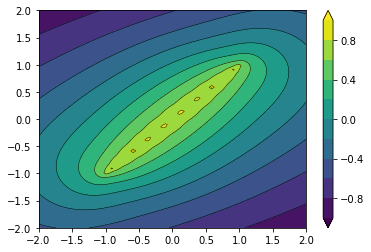

In [123]:
stress = slip
disp = np.sum(S * stress[None, None, :, :], axis=(2, 3))
v2d = disp.reshape((nobs, nobs, 2))[:, :, 0]
levels = np.linspace(-1, 1, 11)
cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
plt.contour(
    xs,
    ys,
    v2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()
